# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
          'axes.titleweight': 'bold',
          'axes.labelweight': 'bold',
         'xtick.labelsize':'xx-large',
          'xtick.major.size': 5.5,
         'ytick.labelsize':'xx-large',
          'ytick.major.size': 5.5,
          'axes.labelpad': 15.0,
          'grid.color': 'gray',
         'axes.edgecolor': 'black'}
pylab.rcParams.update(params)
plt.rcParams["patch.force_edgecolor"] = True

In [2]:
file1 = '/Users/charisameeker/Documents/Data/relax_challenge/takehome_user_engagement.csv'
file2 = '/Users/charisameeker/Documents/Data/relax_challenge/takehome_users.csv'
df1 = pd.read_csv(file1, parse_dates=['time_stamp'],
                 dtype={'user_id':np.int16, 'visited':np.int8})
df2 = pd.read_csv(file2, parse_dates=['creation_time'], encoding='latin-1',
                 dtype={'object_id':np.int16,'opted_in_to_mailing_list':np.int8,
                       'enabled_for_marketing_drip':np.int8,'org_id':np.int16,
                       'invited_by_user_id':np.float32})

# Inspect DataFrames and Create Adopted Column

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int16         
 2   visited     207917 non-null  int8          
dtypes: datetime64[ns](1), int16(1), int8(1)
memory usage: 2.2 MB


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int16         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int8          
 7   enabled_for_marketing_drip  12000 non-null  int8          
 8   org_id                      12000 non-null  int16         
 9   invited_by_user_id          6417 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(1), int16(2), int8(2), object(3)
memory usage: 586.1+ KB


In [5]:
# df2.last_session_creation_time = df2.last_session_creation_time.astype('float64')
# this effectively converts the column to np.inf

In [6]:
df2.object_id.max(), df2.index.max()

(12000, 11999)

In [7]:
df2.set_index('object_id', inplace=True)
df2.index.name = 'user_id'

In [8]:
df2.creation_time.max() - df2.creation_time.min()

Timedelta('729 days 23:15:52')

In [9]:
df2.name.nunique()

11355

## Create Adopted Column

In [10]:
# define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [11]:
# run the function on all users
adopted = df1.groupby('user_id').apply(logins_in_days)
adopted = adopted.astype('int8')

In [12]:
# create a feature of user history
# convert both time features into datetime
'''df2['creation_time'] = pd.to_datetime(
    df2['creation_time'], format='%Y-%m-%d %H:%M:%S')'''
df2['last_session_creation_time'] = pd.to_datetime(
    df2['last_session_creation_time'], unit='s')

# calculate user history, defined as number of days between account creation and last use
df2['history'] = df2['last_session_creation_time'] - df2['creation_time']
df2['history'] = df2['history'].dt.days

# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(df2['creation_time'])
df2['account_age'] = latest - df2['creation_time']
df2['account_age'] = df2['account_age'].dt.days

In [13]:
df2.insert(1, 'adopted', adopted)

# EDA

In [14]:
df1.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [15]:
df2.head(3)

,creation_time,adopted,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,account_age
user_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,0.0,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,38
2,2013-11-15 03:45:04,1.0,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0,196
3,2013-03-19 23:14:52,0.0,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,437


Percentage of Creation Sources: 
ORG_INVITE            0.35
GUEST_INVITE          0.18
PERSONAL_PROJECTS     0.18
SIGNUP                0.17
SIGNUP_GOOGLE_AUTH    0.12
Name: creation_source, dtype: float64


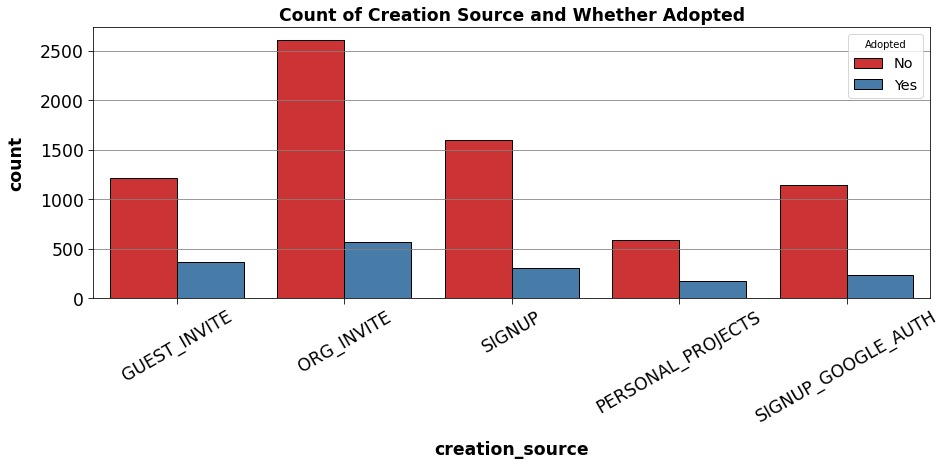

In [16]:
sns.countplot(df2.creation_source, hue=df2.adopted, palette='Set1')
plt.title('Count of Creation Source and Whether Adopted'), plt.grid(axis='y'), plt.xticks(rotation=30)
plt.legend(title='Adopted',labels=['No', 'Yes'])
print(f'Percentage of Creation Sources: \n\
{round(df2.creation_source.value_counts(normalize=True), 2)}')

Percentage of Op Ins to Mailing List: 
0    0.75
1    0.25
Name: opted_in_to_mailing_list, dtype: float64


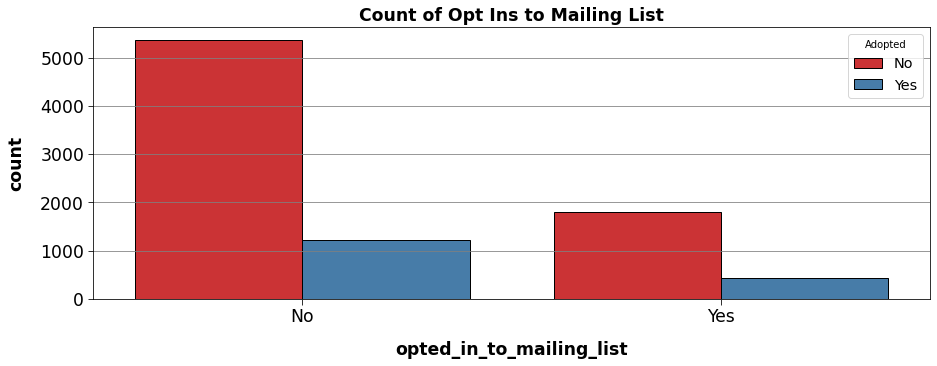

In [17]:
sns.countplot(df2.opted_in_to_mailing_list, palette='Set1', hue=df2.adopted)
plt.title('Count of Opt Ins to Mailing List'), plt.grid(axis='y'), plt.xticks([0,1], ['No','Yes'])
plt.legend(title='Adopted', labels=['No', 'Yes'])
print(f'Percentage of Op Ins to Mailing List: \n\
{round(df2.opted_in_to_mailing_list.value_counts(normalize=True), 2)}')

Percentage of Those Enabled for Marketing Drip: 
0    0.85
1    0.15
Name: enabled_for_marketing_drip, dtype: float64


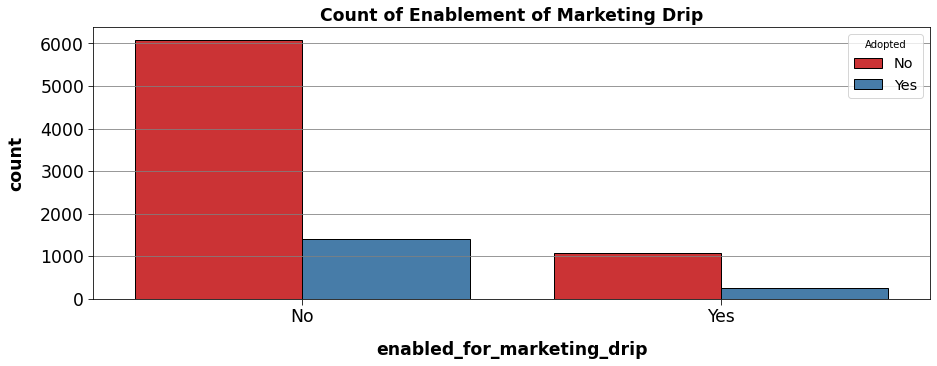

In [18]:
sns.countplot(df2.enabled_for_marketing_drip, palette='Set1', hue=df2.adopted)
plt.title('Count of Enablement of Marketing Drip'), plt.grid(axis='y'), plt.xticks([0,1], ['No','Yes'])
plt.legend(title='Adopted', labels=['No', 'Yes'])
print(f'Percentage of Those Enabled for Marketing Drip: \n\
{round(df2.enabled_for_marketing_drip.value_counts(normalize=True),2)}')

In [19]:
df1.time_stamp.max() - df1.time_stamp.min()

Timedelta('736 days 06:38:44')

In [20]:
df1.user_id.nunique()

8823

In [21]:
df1.visited.nunique()

1

In [22]:
df1.drop('visited', axis=1, inplace=True)

## The column 'visited' adds nothing for our EDA, so I've dropped it.

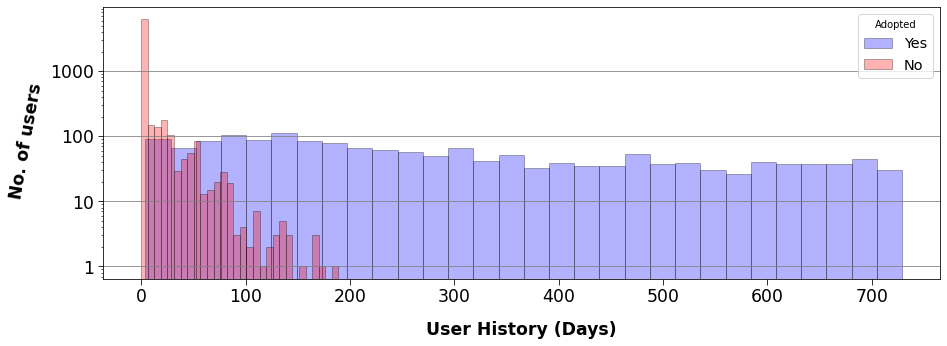

In [23]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[df['adopted']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[df['adopted']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend(title='Adopted',labels=['Yes','No'])
    _ = plt.grid(axis='y')
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users', rotation=80)
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
    
plot_hist_days(df2, 'history', 'User History (Days)')

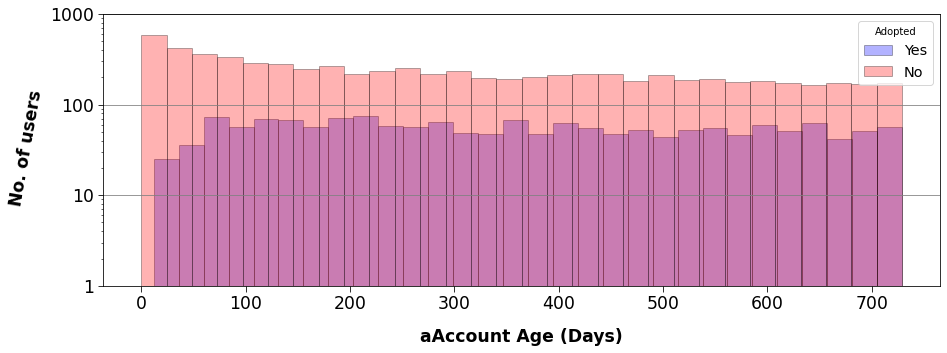

In [24]:
plot_hist_days(df2, 'account_age', 'aAccount Age (Days)')

# NaNs

In [25]:
df1.isna().sum()

time_stamp    0
user_id       0
dtype: int64

In [26]:
def nan_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
    missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
    print(missing_data[missing_data['Total'] > 0].round({'Missing Percent': 3}))
    
nan_percentage(df2)

                            Total  Missing Percent
invited_by_user_id           5583           46.525
history                      3177           26.475
last_session_creation_time   3177           26.475
adopted                      3177           26.475


In [27]:
df2.query('invited_by_user_id == 5', engine='python').shape[0]

0

In [28]:
df2.last_session_creation_time.mean()

Timestamp('2013-09-15 21:08:25.700448768')

## We can't drop the NaN rows, and they are a large percentage of the dataset. This is not ideal. They're both numeric columns. I'll impute the mean in each column because the mean does not appear otherwise.

In [29]:
imr = SimpleImputer(strategy='mean')
imr = imr.fit(df2[['invited_by_user_id']])
df2.invited_by_user_id = imr.transform(df2[['invited_by_user_id']]).ravel()

In [30]:
imr = SimpleImputer(strategy='mean')
imr = imr.fit(df2[['last_session_creation_time']])
df2.last_session_creation_time = imr.transform(df2[['last_session_creation_time']]).ravel()

## Let's consider the history and adopted columns.

In [31]:
df2.query('history.isna()',engine='python').last_session_creation_time.sort_values(ascending=True).head(1)

user_id
8   -9.223372e+18
Name: last_session_creation_time, dtype: float64

In [32]:
df2.query('adopted == 1',engine='python').last_session_creation_time.sort_values(ascending=False).head(1)
# ascending = False

user_id
341    1.401926e+18
Name: last_session_creation_time, dtype: float64

## For those with NaN histories, their last session happened a long time ago, while the longest time ago that an adopted user signed in was much more recent.

In [33]:
df2.history.describe(exclude=[np.nan, None])

count    8823.000000
mean       59.222147
std       144.172167
min         0.000000
25%         0.000000
50%         1.000000
75%        20.000000
max       729.000000
Name: history, dtype: float64

## Because so much data is missing from history and adopted, there's no clean way to impute it. Given that the history column is derived from last_session_creation_time, and that those with nan histories haven't logged in for a long time, it is safest to impute a low score to history and 0 to adopted.

In [34]:
df2.history = df2.history.fillna(0)
df2.adopted = df2.adopted.fillna(0)

In [35]:
df2.isna().sum(), df1.isna().sum()

(creation_time                 0
 adopted                       0
 name                          0
 email                         0
 creation_source               0
 last_session_creation_time    0
 opted_in_to_mailing_list      0
 enabled_for_marketing_drip    0
 org_id                        0
 invited_by_user_id            0
 history                       0
 account_age                   0
 dtype: int64,
 time_stamp    0
 user_id       0
 dtype: int64)

## Now that there are no NaN values, we can minimize the dtypes one final time.

In [36]:
df2.adopted = df2.adopted.astype('int8')
df2.history = df2.history.astype('int16')
df2.account_age = df2.account_age.astype('int16')
df2.creation_source = df2.creation_source.astype('category')

# Dataset Preparation

In [37]:
df2.drop(['name', 'email'], axis=1, inplace=True)

In [38]:
y = df2['adopted'].copy().values
X = df2.copy().drop(['adopted'], axis=1)
X_col = X.copy().columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  category      
 2   last_session_creation_time  12000 non-null  float64       
 3   opted_in_to_mailing_list    12000 non-null  int8          
 4   enabled_for_marketing_drip  12000 non-null  int8          
 5   org_id                      12000 non-null  int16         
 6   invited_by_user_id          12000 non-null  float32       
 7   history                     12000 non-null  int16         
 8   account_age                 12000 non-null  int16         
dtypes: category(1), datetime64[ns](1), float32(1), float64(1), int16(3), int8(2)
memory usage: 433.8 KB


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#pipeline for numeric features
numeric_features = ['last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', \
                   'org_id', 'invited_by_user_id', 'history', 'account_age']
numeric_transformer = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

#pipeline for categorical features
categorical_features = ["creation_source"]
categorical_transformer = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

#divernce of the pipelines
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), \
                  ("cat", categorical_transformer, categorical_features)])

#incorporating the random forest estimator
pipeline = Pipeline(steps=[("pre", preprocessor), \
                           ("rf", RandomForestClassifier(random_state = 42))])

#grid search parameters
params = {"rf__n_estimators" : [75, 100, 150],
          "rf__max_depth" : [5, 10, 15]}

#fitting the pipeline to the grid search
cv1 = GridSearchCV(pipeline, param_grid=params, cv=3)
cv1.fit(X_train, y_train)

print(cv1)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['last_session_creation_time',
                                                                          'opted_in_to_mailing_list',
                                                                          'enabled_for_marketing_drip',
                                                                          'org_id',
                                                                          'invited_by_user_id',
                                                                          'history',
                                                                    

In [41]:
print(f"Best parameters: {cv1.best_params_}")
print(f"Training accuracy score from tuned model: {cv1.best_score_*100:.1f}%")

Best parameters: {'rf__max_depth': 5, 'rf__n_estimators': 150}
Training accuracy score from tuned model: 97.2%


## Great results. Let's explore feature importance.

In [42]:
pipeline.fit(X_train, y_train)

fe1 = pipeline.named_steps['rf'].feature_importances_

print(fe1)

[0.24767903 0.00337491 0.00278404 0.0321454  0.02029189 0.61270901
 0.06824141 0.00220044 0.00270069 0.00300142 0.00222294 0.00264881]


In [43]:
#replicating numeric_transformer of our pipeline
num_cols = df2[numeric_features].columns
num_cols = num_cols.tolist()

#replicating categorical_transformer of our pipeline
cat_cols = pd.get_dummies(df2[categorical_features]).columns
cat_cols = cat_cols.tolist()

#the column names are added together
cols = num_cols + cat_cols

#the column names are finally tied to our fe list
feature_importance = zip(cols, fe1)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

for i, j in feature_importance:
    print(f"Weight: {j:.3f} | Feature: {i}")

Weight: 0.613 | Feature: history
Weight: 0.248 | Feature: last_session_creation_time
Weight: 0.068 | Feature: account_age
Weight: 0.032 | Feature: org_id
Weight: 0.020 | Feature: invited_by_user_id
Weight: 0.003 | Feature: opted_in_to_mailing_list
Weight: 0.003 | Feature: creation_source_PERSONAL_PROJECTS
Weight: 0.003 | Feature: enabled_for_marketing_drip
Weight: 0.003 | Feature: creation_source_ORG_INVITE
Weight: 0.003 | Feature: creation_source_SIGNUP_GOOGLE_AUTH
Weight: 0.002 | Feature: creation_source_SIGNUP
Weight: 0.002 | Feature: creation_source_GUEST_INVITE


In [44]:
from sklearn.metrics import classification_report
y_pred = cv1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2580
           1       0.94      0.90      0.92       420

    accuracy                           0.98      3000
   macro avg       0.96      0.94      0.95      3000
weighted avg       0.98      0.98      0.98      3000



### 2. AdaBoost Classifier

In [45]:
from sklearn.ensemble import AdaBoostClassifier

#pipeline for numeric features
numeric_features = ['last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', \
                   'org_id', 'invited_by_user_id', 'history', 'account_age']
numeric_transformer = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

#pipeline for categorical features
categorical_features = ["creation_source"]
categorical_transformer = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

#divernce of the pipelines
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), \
                  ("cat", categorical_transformer, categorical_features)])

#incorporating the random forest estimator
pipeline = Pipeline(steps=[("pre", preprocessor), \
                           ("ab", AdaBoostClassifier(random_state = 42))])

#grid search parameters
params = {"ab__n_estimators" : [75, 100, 150],
          "ab__learning_rate" : [.25, .5, .75, 1]}

#fitting the pipeline to the grid search
cv2 = GridSearchCV(pipeline, param_grid=params, cv=3)
cv2.fit(X_train, y_train)

print(cv2)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['last_session_creation_time',
                                                                          'opted_in_to_mailing_list',
                                                                          'enabled_for_marketing_drip',
                                                                          'org_id',
                                                                          'invited_by_user_id',
                                                                          'history',
                                                                    

In [46]:
print(f"Best parameters: {cv1.best_params_}")
print(f"Training accuracy score from tuned model: {cv1.best_score_*100:.1f}%")

Best parameters: {'rf__max_depth': 5, 'rf__n_estimators': 150}
Training accuracy score from tuned model: 97.2%


In [47]:
pipeline.fit(X_train, y_train)

fe2 = pipeline.named_steps['ab'].feature_importances_

print(fe2)

[0.22 0.   0.   0.14 0.06 0.4  0.18 0.   0.   0.   0.   0.  ]


In [48]:
#replicating numeric_transformer of our pipeline
num_cols = df2[numeric_features].columns
num_cols = num_cols.tolist()

#replicating categorical_transformer of our pipeline
cat_cols = pd.get_dummies(df2[categorical_features]).columns
cat_cols = cat_cols.tolist()

#the column names are added together
cols = num_cols + cat_cols

#the column names are finally tied to our fe list
feature_importance = zip(cols, fe1)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

for i, j in feature_importance:
    print(f"Weight: {j:.3f} | Feature: {i}")

Weight: 0.613 | Feature: history
Weight: 0.248 | Feature: last_session_creation_time
Weight: 0.068 | Feature: account_age
Weight: 0.032 | Feature: org_id
Weight: 0.020 | Feature: invited_by_user_id
Weight: 0.003 | Feature: opted_in_to_mailing_list
Weight: 0.003 | Feature: creation_source_PERSONAL_PROJECTS
Weight: 0.003 | Feature: enabled_for_marketing_drip
Weight: 0.003 | Feature: creation_source_ORG_INVITE
Weight: 0.003 | Feature: creation_source_SIGNUP_GOOGLE_AUTH
Weight: 0.002 | Feature: creation_source_SIGNUP
Weight: 0.002 | Feature: creation_source_GUEST_INVITE


In [49]:
from sklearn.metrics import classification_report
y_pred = cv1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2580
           1       0.94      0.90      0.92       420

    accuracy                           0.98      3000
   macro avg       0.96      0.94      0.95      3000
weighted avg       0.98      0.98      0.98      3000



### The model performs the same as the RF Classifier. 

# So What?

## We all know that correlation does not equal causation. Still, given that we can't piece together the exact causal relationships with onmiscience before making costly decisions, what have we learned about adopted status? It's clear that there are only two primary features, and they are closely related: history and the last time a user logged in. I recommend fostering methods that encourage users to log in more often, perhaps by push notifications to their phone.